<a href="https://colab.research.google.com/github/osgeokr/kari-sdm/blob/main/009_sdm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U rasterio

In [2]:
import pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import os
import numpy as np

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [12]:
# Google Drive를 마운트
drive.mount('/content/drive')

# 경로 설정
folder_path = "/content/drive/My Drive/kari-sdm"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
gdf = gpd.read_file(os.path.join(folder_path, "pitta_nympha_pa_dw.gpkg"))
gdf.head(1)

,species,status,geometry
0,Pitta nympha,1,POINT (126.69344 33.36925)


In [5]:
# 좌표에 대한 픽셀 값을 샘플링하여 새 필드 추가
def sample_raster(raster, points_gdf):
    values = []
    for geom in points_gdf.geometry:
        if geom.geom_type == 'Point':
            point = geom
            try:
                for val in raster.sample([(point.x, point.y)]):
                    values.append(val[0])
            except ValueError:
                values.append(None)
        else:
            values.append(None)
    return values

In [6]:
# DEM
img_path = os.path.join(folder_path, "DEM_scaled.tif")
dem = rasterio.open(img_path)
gdf['dem'] = sample_raster(dem, gdf)

# SLP
img_path = os.path.join(folder_path, "SLP_scaled.tif")
slp = rasterio.open(img_path)
gdf['slp'] = sample_raster(slp, gdf)

# ASP
img_path = os.path.join(folder_path, "ASP_scaled.tif")
asp = rasterio.open(img_path)
gdf['asp'] = sample_raster(asp, gdf)

# NDBI
img_path = os.path.join(folder_path, "NDBI_scaled.tif")
ndbi = rasterio.open(img_path)
gdf['ndbi'] = sample_raster(ndbi, gdf)

# NDVI
img_path = os.path.join(folder_path, "NDVI_scaled.tif")
ndvi = rasterio.open(img_path)
gdf['ndvi'] = sample_raster(ndvi, gdf)

# NDWI
img_path = os.path.join(folder_path, "NDWI_scaled.tif")
ndwi = rasterio.open(img_path)
gdf['ndwi'] = sample_raster(ndwi, gdf)

# Canopy Height
img_path = os.path.join(folder_path, "CHT_scaled.tif")
cht = rasterio.open(img_path)
gdf['cht'] = sample_raster(cht, gdf)

# Tree Canopy Cover
img_path = os.path.join(folder_path, "TCC_scaled.tif")
tcc = rasterio.open(img_path)
gdf['tcc'] = sample_raster(tcc, gdf)

# 결과 출력
gdf.head(1)

,species,status,geometry,dem,slp,asp,ndbi,ndvi,ndwi,cht,tcc
0,Pitta nympha,1,POINT (126.69344 33.36925),0.243802,0.125,0.445682,0.290305,0.877249,0.102141,0.617647,0.58046


In [7]:
# NaN 값이 있는 레코드 필터링
nan_gdf = gdf[
    gdf[["dem", "slp", "asp", "ndbi", "ndvi", "ndwi", "cht", "tcc"]].isna().any(axis=1)
]

# NaN 값이 있는 좌표의 개수 출력
nan_count = nan_gdf.shape[0]
print(f"NaN 값이 있는 좌표의 개수: {nan_count}개")

# NaN 값이 있는 좌표를 삭제
gdf_cleaned = gdf.dropna(
    subset=["dem", "slp", "asp", "ndbi", "ndvi", "ndwi", "cht", "tcc"]
)

# NaN이 있는 좌표가 삭제된 결과 출력 (원래 gdf를 gdf_cleaned로 업데이트)
gdf = gdf_cleaned

NaN 값이 있는 좌표의 개수: 0개


In [8]:
# 7:3 비율로 train과 test 데이터셋 나누기
train_gdf, test_gdf = train_test_split(
    gdf, test_size=0.3, random_state=42, stratify=gdf["status"]
)

# 특징 변수와 라벨 준비
X_train = train_gdf[['dem', 'slp', 'asp', 'ndbi', 'ndvi', 'ndwi', 'cht', 'tcc']]
y_train = train_gdf['status']
X_test = test_gdf[['dem', 'slp', 'asp', 'ndbi', 'ndvi', 'ndwi', 'cht', 'tcc']]
y_test = test_gdf['status']

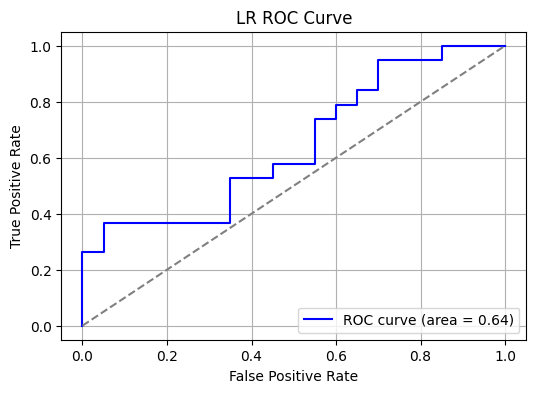

In [9]:
# Logistic Regression 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측 및 ROC 커브 그리기
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [10]:
# SDM 지도 래스터 생성
dem_array = dem.read(1)
slp_array = slp.read(1)
asp_array = asp.read(1)
ndbi_array = ndbi.read(1)
ndvi_array = ndvi.read(1)
ndwi_array = ndwi.read(1)
cht_array = cht.read(1)
tcc_array = tcc.read(1)

In [11]:
# 래스터 배열에서 값이 유효한 위치를 선택하여 모델 예측 수행
valid_mask = (
    ~np.isnan(dem_array)
    & ~np.isnan(slp_array)
    & ~np.isnan(asp_array)
    & ~np.isnan(ndbi_array)
    & ~np.isnan(ndvi_array)
    & ~np.isnan(ndwi_array)
    & ~np.isnan(cht_array)
    & ~np.isnan(tcc_array)
)

In [ ]:
X_valid = np.column_stack([dem_array[valid_mask], slp_array[valid_mask], asp_array[valid_mask],
                           ndbi_array[valid_mask], ndvi_array[valid_mask], ndwi_array[valid_mask],
                           cht_array[valid_mask], tcc_array[valid_mask]])

# 예측을 위해 NumPy 배열을 DataFrame으로 변환
X_valid_df = pd.DataFrame(X_valid, columns=['dem', 'slp', 'asp', 'ndbi', 'ndvi', 'ndwi', 'cht', 'tcc'])

# 모델 예측 수행
y_pred_valid = model.predict_proba(X_valid_df)[:, 1]

# SDM 예측 결과를 저장할 배열 생성
sdm_map = np.full(dem_array.shape, np.nan)
sdm_map[valid_mask] = y_pred_valid

# GeoTIFF 저장을 위한 메타데이터 설정
transform = dem.transform
meta = dem.meta.copy()
meta.update({
    'dtype': 'float32',
    'count': 1,
    'compress': 'lzw'
})

# GeoTIFF로 저장
output_path = os.path.join(folder_path, "SDM_LR.tif")
with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(sdm_map, 1)

print(f"SDM prediction map saved to {output_path}")

SDM prediction map saved to /content/drive/My Drive/kari-sdm/SDM_LR.tif


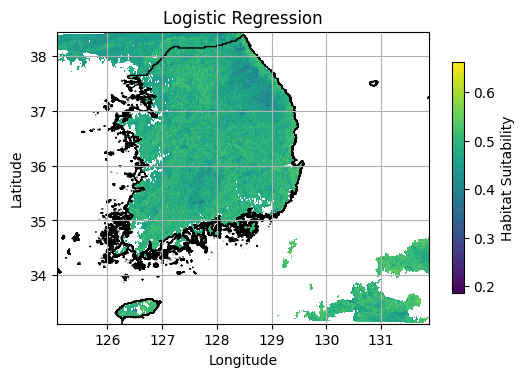

In [ ]:
# 경로 설정
folder_path = "/content/drive/My Drive/kari-sdm"
img_path = os.path.join(folder_path, "SDM_LR.tif")
kr_path = os.path.join(folder_path, "KR.gpkg")

# 대한민국 경계 읽기
kr = gpd.read_file(kr_path)

# 이미지 데이터 읽기
with rasterio.open(img_path) as src:
    img_data = src.read(1)  # 첫 번째 밴드 읽기
    img_extent = src.bounds  # 이미지의 범위 가져오기
    img_transform = src.transform  # 변환 정보 가져오기
    img_meta = src.meta.copy()  # 메타데이터 복사

# 플롯 설정
fig, ax = plt.subplots(figsize=(6, 6))

# 이미지 데이터 플롯 (마스킹 적용)
img_plot = ax.imshow(
    img_data,
    cmap="viridis",
    extent=[img_extent.left, img_extent.right, img_extent.bottom, img_extent.top],
    origin="upper"
)

# 대한민국 경계 플롯
kr.plot(ax=ax, color="none", edgecolor="black")

# 컬러바(범례) 추가
cbar = fig.colorbar(img_plot, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Habitat Suitability')

# 제목, 축 레이블, 그리드 설정
plt.title("Logistic Regression")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# 좌표 비율 유지
ax.set_aspect("equal", "box")

# 플롯 표시
plt.show()

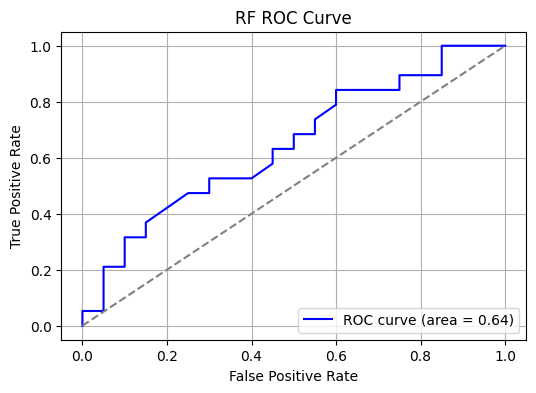

In [ ]:
# Random Forest 모델 학습
model = RandomForestClassifier()
model.fit(X_train, y_train)

# 예측 및 ROC 커브 그리기
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
X_valid = np.column_stack([dem_array[valid_mask], slp_array[valid_mask], asp_array[valid_mask],
                           ndbi_array[valid_mask], ndvi_array[valid_mask], ndwi_array[valid_mask],
                           cht_array[valid_mask], tcc_array[valid_mask]])

# 예측을 위해 NumPy 배열을 DataFrame으로 변환
X_valid_df = pd.DataFrame(X_valid, columns=['dem', 'slp', 'asp', 'ndbi', 'ndvi', 'ndwi', 'cht', 'tcc'])

# 모델 예측 수행
y_pred_valid = model.predict_proba(X_valid_df)[:, 1]

# SDM 예측 결과를 저장할 배열 생성
sdm_map = np.full(dem_array.shape, np.nan)
sdm_map[valid_mask] = y_pred_valid

# GeoTIFF 저장을 위한 메타데이터 설정
transform = dem.transform
meta = dem.meta.copy()
meta.update({
    'dtype': 'float32',
    'count': 1,
    'compress': 'lzw'
})

# GeoTIFF로 저장
output_path = os.path.join(folder_path, "SDM_RF.tif")
with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(sdm_map, 1)

print(f"SDM prediction map saved to {output_path}")

SDM prediction map saved to /content/drive/My Drive/kari-sdm/SDM_RF.tif


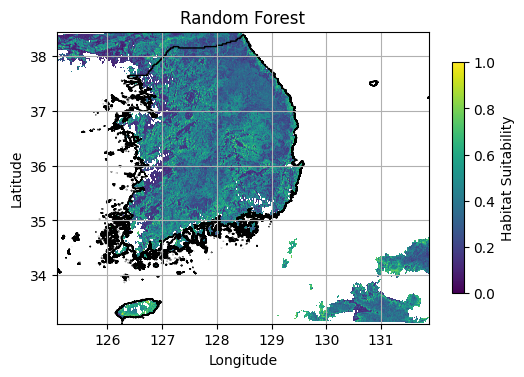

In [ ]:
# 경로 설정
img_path = os.path.join(folder_path, "SDM_RF.tif")

# 대한민국 경계 읽기
kr = gpd.read_file(kr_path)

# 이미지 데이터 읽기
with rasterio.open(img_path) as src:
    img_data = src.read(1)  # 첫 번째 밴드 읽기
    img_extent = src.bounds  # 이미지의 범위 가져오기
    img_transform = src.transform  # 변환 정보 가져오기
    img_meta = src.meta.copy()  # 메타데이터 복사

# 플롯 설정
fig, ax = plt.subplots(figsize=(6, 6))

# 이미지 데이터 플롯 (마스킹 적용)
img_plot = ax.imshow(
    img_data,
    cmap="viridis",
    extent=[img_extent.left, img_extent.right, img_extent.bottom, img_extent.top],
    origin="upper"
)

# 대한민국 경계 플롯
kr.plot(ax=ax, color="none", edgecolor="black")

# 컬러바(범례) 추가
cbar = fig.colorbar(img_plot, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Habitat Suitability')

# 제목, 축 레이블, 그리드 설정
plt.title("Random Forest")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# 좌표 비율 유지
ax.set_aspect("equal", "box")

# 플롯 표시
plt.show()

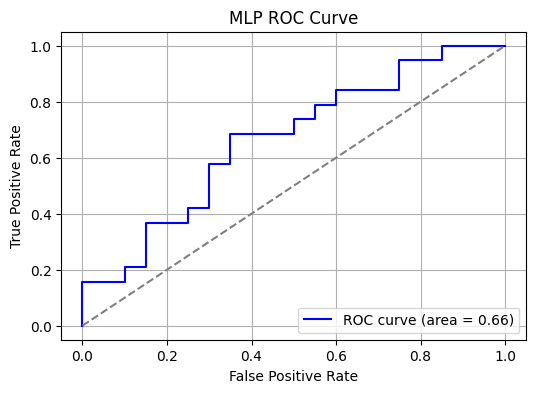

In [10]:
# PyTorch 데이터셋 및 데이터로더 생성
train_dataset = TensorDataset(torch.tensor(X_train.to_numpy(), dtype=torch.float32), torch.tensor(y_train.to_numpy(), dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test.to_numpy(), dtype=torch.float32), torch.tensor(y_test.to_numpy(), dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

model = MLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# 모델 평가 및 ROC 커브 그리기
model.eval()
y_pred_prob = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch).squeeze().numpy()
        y_pred_prob.extend(y_pred)
        y_true.extend(y_batch.numpy())

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [14]:
# SDM 예측 결과를 저장할 전체 맵 생성
sdm_map = np.full(dem.shape, np.nan, dtype=np.float32)

def process_chunk(window, model):
    # 각 래스터에서 현재 창(window)에 해당하는 데이터를 읽어옵니다.
    dem_chunk = dem.read(1, window=window)
    slp_chunk = slp.read(1, window=window)
    asp_chunk = asp.read(1, window=window)
    ndbi_chunk = ndbi.read(1, window=window)
    ndvi_chunk = ndvi.read(1, window=window)
    ndwi_chunk = ndwi.read(1, window=window)
    cht_chunk = cht.read(1, window=window)
    tcc_chunk = tcc.read(1, window=window)

    # 유효한 값들에 대한 마스크를 생성
    valid_mask = (
        ~np.isnan(dem_chunk)
        & ~np.isnan(slp_chunk)
        & ~np.isnan(asp_chunk)
        & ~np.isnan(ndbi_chunk)
        & ~np.isnan(ndvi_chunk)
        & ~np.isnan(ndwi_chunk)
        & ~np.isnan(cht_chunk)
        & ~np.isnan(tcc_chunk)
    )

    # 유효한 위치의 데이터만 선택하여 모델 예측에 사용
    X_valid_chunk = np.column_stack([dem_chunk[valid_mask], slp_chunk[valid_mask], asp_chunk[valid_mask],
                                     ndbi_chunk[valid_mask], ndvi_chunk[valid_mask], ndwi_chunk[valid_mask],
                                     cht_chunk[valid_mask], tcc_chunk[valid_mask]])

    if X_valid_chunk.size == 0:
        return None, None, None  # 유효한 데이터가 없는 경우 건너뜁니다.

    X_valid_tensor_chunk = torch.tensor(X_valid_chunk, dtype=torch.float32)
    with torch.no_grad():
        sdm_valid_chunk = model(X_valid_tensor_chunk).squeeze().numpy()

    return sdm_valid_chunk, valid_mask, dem_chunk.shape

# GeoTIFF 저장을 위한 메타데이터 설정
transform = dem.transform
meta = dem.meta.copy()
meta.update({
    'dtype': 'float32',
    'count': 1,
    'compress': 'lzw'
})

# 결과를 저장할 경로 설정
output_path = os.path.join(folder_path, "SDM_MLP.tif")

# 전체 래스터에 대해 작은 창 단위로 반복합니다.
with rasterio.open(output_path, 'w', **meta) as dst:
    with rasterio.open(dem.name) as src:
        for ji, window in src.block_windows(1):
            sdm_valid_chunk, valid_mask, chunk_shape = process_chunk(window, model)
            if sdm_valid_chunk is not None:
                # sdm_map의 해당 위치에 예측 결과를 업데이트
                sdm_map_chunk = np.full(chunk_shape, np.nan, dtype=np.float32)
                sdm_map_chunk[valid_mask] = sdm_valid_chunk

                # 예측 결과를 GeoTIFF로 저장
                dst.write(sdm_map_chunk, window=window, indexes=1)

print(f"SDM prediction map saved to {output_path}")

SDM prediction map saved to /content/drive/My Drive/kari-sdm/SDM_MLP.tif


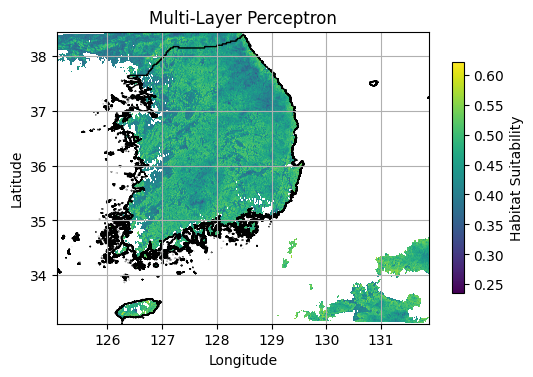

In [17]:
# 경로 설정
img_path = os.path.join(folder_path, "SDM_MLP.tif")
kr_path = os.path.join(folder_path, "KR.gpkg")

# 대한민국 경계 읽기
kr = gpd.read_file(kr_path)

# 이미지 데이터 읽기
with rasterio.open(img_path) as src:
    img_data = src.read(1)  # 첫 번째 밴드 읽기
    img_extent = src.bounds  # 이미지의 범위 가져오기
    img_transform = src.transform  # 변환 정보 가져오기
    img_meta = src.meta.copy()  # 메타데이터 복사

# 플롯 설정
fig, ax = plt.subplots(figsize=(6, 6))

# 이미지 데이터 플롯 (마스킹 적용)
img_plot = ax.imshow(
    img_data,
    cmap="viridis",
    extent=[img_extent.left, img_extent.right, img_extent.bottom, img_extent.top],
    origin="upper"
)

# 대한민국 경계 플롯
kr.plot(ax=ax, color="none", edgecolor="black")

# 컬러바(범례) 추가
cbar = fig.colorbar(img_plot, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Habitat Suitability')

# 제목, 축 레이블, 그리드 설정
plt.title("Multi-Layer Perceptron")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# 좌표 비율 유지
ax.set_aspect("equal", "box")

# 플롯 표시
plt.show()

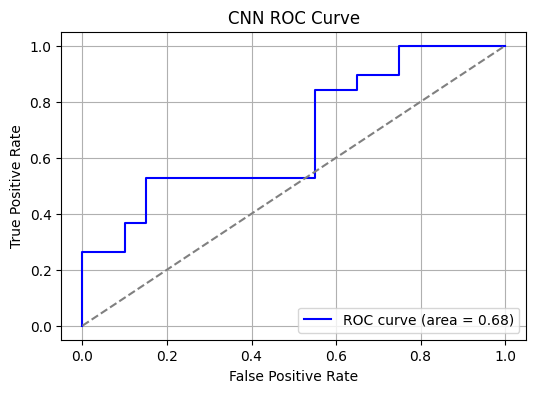

In [23]:
# PyTorch 데이터셋 및 데이터로더 생성
train_dataset = TensorDataset(torch.tensor(X_train.to_numpy(), dtype=torch.float32).unsqueeze(1),
                              torch.tensor(y_train.to_numpy(), dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test.to_numpy(), dtype=torch.float32).unsqueeze(1),
                             torch.tensor(y_test.to_numpy(), dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=2, stride=1)

        # 입력 크기가 8일 때 Conv1d 레이어의 출력 크기 계산
        conv_output_size = (8 - 2) // 1 + 1  # 7이 됩니다.

        self.fc1 = nn.Linear(16 * conv_output_size, 32)  # 16 * 7 = 112
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = CNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# 모델 평가 및 ROC 커브 그리기
model.eval()
y_pred_prob = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch).squeeze().cpu().numpy()  # 수정된 부분
        y_pred_prob.extend(y_pred)
        y_true.extend(y_batch.numpy())

fpr, tpr, _ = roc_curve(y_test, np.array(y_pred_prob))  # y_pred_prob을 numpy 배열로 변환
roc_auc = roc_auc_score(y_test, np.array(y_pred_prob))

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### 2D CNN으로 변경하기
2D CNN을 적용하기 위해서는 데이터가 2차원이어야 한다. 만약 X_train과 X_test가 2차원 배열(예: [batch_size, height, width])이라면, 이를 4차원으로 확장해야 합니다([batch_size, channels, height, width]).

In [24]:
# SDM 예측 결과를 저장할 전체 맵 생성
sdm_map = np.full(dem.shape, np.nan, dtype=np.float32)

def process_chunk(window, model):
    # 각 래스터에서 현재 창(window)에 해당하는 데이터를 읽어옵니다.
    dem_chunk = dem.read(1, window=window)
    slp_chunk = slp.read(1, window=window)
    asp_chunk = asp.read(1, window=window)
    ndbi_chunk = ndbi.read(1, window=window)
    ndvi_chunk = ndvi.read(1, window=window)
    ndwi_chunk = ndwi.read(1, window=window)
    cht_chunk = cht.read(1, window=window)
    tcc_chunk = tcc.read(1, window=window)

    # 유효한 값들에 대한 마스크를 생성
    valid_mask = (
        ~np.isnan(dem_chunk)
        & ~np.isnan(slp_chunk)
        & ~np.isnan(asp_chunk)
        & ~np.isnan(ndbi_chunk)
        & ~np.isnan(ndvi_chunk)
        & ~np.isnan(ndwi_chunk)
        & ~np.isnan(cht_chunk)
        & ~np.isnan(tcc_chunk)
    )

    # 유효한 위치의 데이터만 선택하여 모델 예측에 사용
    X_valid_chunk = np.column_stack([dem_chunk[valid_mask], slp_chunk[valid_mask], asp_chunk[valid_mask],
                                     ndbi_chunk[valid_mask], ndvi_chunk[valid_mask], ndwi_chunk[valid_mask],
                                     cht_chunk[valid_mask], tcc_chunk[valid_mask]])

    if X_valid_chunk.size == 0:
        return None, None, None  # 유효한 데이터가 없는 경우 건너뜁니다.

    X_valid_tensor_chunk = torch.tensor(X_valid_chunk, dtype=torch.float32)
    with torch.no_grad():
        sdm_valid_chunk = model(X_valid_tensor_chunk).squeeze().numpy()

    return sdm_valid_chunk, valid_mask, dem_chunk.shape

# GeoTIFF 저장을 위한 메타데이터 설정
transform = dem.transform
meta = dem.meta.copy()
meta.update({
    'dtype': 'float32',
    'count': 1,
    'compress': 'lzw'
})

# 결과를 저장할 경로 설정
output_path = os.path.join(folder_path, "SDM_CNN.tif")

# 전체 래스터에 대해 작은 창 단위로 반복합니다.
with rasterio.open(output_path, 'w', **meta) as dst:
    with rasterio.open(dem.name) as src:
        for ji, window in src.block_windows(1):
            sdm_valid_chunk, valid_mask, chunk_shape = process_chunk(window, model)
            if sdm_valid_chunk is not None:
                # sdm_map의 해당 위치에 예측 결과를 업데이트
                sdm_map_chunk = np.full(chunk_shape, np.nan, dtype=np.float32)
                sdm_map_chunk[valid_mask] = sdm_valid_chunk

                # 예측 결과를 GeoTIFF로 저장
                dst.write(sdm_map_chunk, window=window, indexes=1)

print(f"SDM prediction map saved to {output_path}")

RuntimeError: Given groups=1, weight of size [16, 1, 2], expected input[1, 886, 8] to have 1 channels, but got 886 channels instead

In [25]:
# SDM 예측 결과를 저장할 전체 맵 생성
sdm_map = np.full(dem.shape, np.nan, dtype=np.float32)

def process_chunk(window, model):
    # 각 래스터에서 현재 창(window)에 해당하는 데이터를 읽어옵니다.
    dem_chunk = dem.read(1, window=window)
    slp_chunk = slp.read(1, window=window)
    asp_chunk = asp.read(1, window=window)
    ndbi_chunk = ndbi.read(1, window=window)
    ndvi_chunk = ndvi.read(1, window=window)
    ndwi_chunk = ndwi.read(1, window=window)
    cht_chunk = cht.read(1, window=window)
    tcc_chunk = tcc.read(1, window=window)

    # 유효한 값들에 대한 마스크를 생성
    valid_mask = (
        ~np.isnan(dem_chunk)
        & ~np.isnan(slp_chunk)
        & ~np.isnan(asp_chunk)
        & ~np.isnan(ndbi_chunk)
        & ~np.isnan(ndvi_chunk)
        & ~np.isnan(ndwi_chunk)
        & ~np.isnan(cht_chunk)
        & ~np.isnan(tcc_chunk)
    )

    # 유효한 위치의 데이터만 선택하여 모델 예측에 사용
    X_valid_chunk = np.column_stack([dem_chunk[valid_mask], slp_chunk[valid_mask], asp_chunk[valid_mask],
                                     ndbi_chunk[valid_mask], ndvi_chunk[valid_mask], ndwi_chunk[valid_mask],
                                     cht_chunk[valid_mask], tcc_chunk[valid_mask]])

    if X_valid_chunk.size == 0:
        return None, None, None  # 유효한 데이터가 없는 경우 건너뜁니다.

    # 모델 입력 데이터 형태 조정 (batch_size, 1, features)
    X_valid_tensor_chunk = torch.tensor(X_valid_chunk, dtype=torch.float32).unsqueeze(1)

    # GPU 사용 시 텐서를 GPU로 이동
    if torch.cuda.is_available():
        X_valid_tensor_chunk = X_valid_tensor_chunk.to('cuda')
        model = model.to('cuda')

    with torch.no_grad():
        sdm_valid_chunk = model(X_valid_tensor_chunk).squeeze().cpu().numpy()

    return sdm_valid_chunk, valid_mask, dem_chunk.shape

# GeoTIFF 저장을 위한 메타데이터 설정
transform = dem.transform
meta = dem.meta.copy()
meta.update({
    'dtype': 'float32',
    'count': 1,
    'compress': 'lzw'
})

# 결과를 저장할 경로 설정
output_path = os.path.join(folder_path, "SDM_CNN.tif")

# 전체 래스터에 대해 작은 창 단위로 반복합니다.
with rasterio.open(output_path, 'w', **meta) as dst:
    with rasterio.open(dem.name) as src:
        for ji, window in src.block_windows(1):
            sdm_valid_chunk, valid_mask, chunk_shape = process_chunk(window, model)
            if sdm_valid_chunk is not None:
                # sdm_map의 해당 위치에 예측 결과를 업데이트
                sdm_map_chunk = np.full(chunk_shape, np.nan, dtype=np.float32)
                sdm_map_chunk[valid_mask] = sdm_valid_chunk

                # 예측 결과를 GeoTIFF로 저장
                dst.write(sdm_map_chunk, window=window, indexes=1)

print(f"SDM prediction map saved to {output_path}")

SDM prediction map saved to /content/drive/My Drive/kari-sdm/SDM_CNN.tif


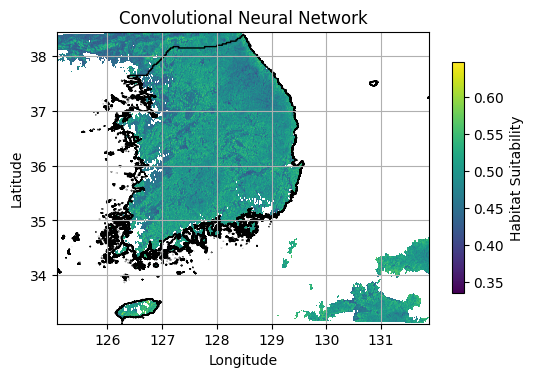

In [26]:
# 경로 설정
img_path = os.path.join(folder_path, "SDM_CNN.tif")
kr_path = os.path.join(folder_path, "KR.gpkg")

# 대한민국 경계 읽기
kr = gpd.read_file(kr_path)

# 이미지 데이터 읽기
with rasterio.open(img_path) as src:
    img_data = src.read(1)  # 첫 번째 밴드 읽기
    img_extent = src.bounds  # 이미지의 범위 가져오기
    img_transform = src.transform  # 변환 정보 가져오기
    img_meta = src.meta.copy()  # 메타데이터 복사

# 플롯 설정
fig, ax = plt.subplots(figsize=(6, 6))

# 이미지 데이터 플롯 (마스킹 적용)
img_plot = ax.imshow(
    img_data,
    cmap="viridis",
    extent=[img_extent.left, img_extent.right, img_extent.bottom, img_extent.top],
    origin="upper"
)

# 대한민국 경계 플롯
kr.plot(ax=ax, color="none", edgecolor="black")

# 컬러바(범례) 추가
cbar = fig.colorbar(img_plot, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Habitat Suitability')

# 제목, 축 레이블, 그리드 설정
plt.title("Convolutional Neural Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# 좌표 비율 유지
ax.set_aspect("equal", "box")

# 플롯 표시
plt.show()